In [173]:
#data handling, model creation/evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LassoCV, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, KFold
import scipy.stats as stats
from yellowbrick.regressor import ResidualsPlot
import statsmodels.api as sm

# visualization
%matplotlib inline
import seaborn as sns

# Read Pickles

In [404]:
main_df = pd.read_pickle('data/df_main.pkl')
dummy_df = pd.read_pickle('df_dummies.pkl')
df = main_df.merge(dummy_df.drop(['avg_rating','owned'], axis=1), left_index=True, right_index=True)

# More Cleaning

In [405]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120832 entries, 0 to 120831
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   owned          120832 non-null  int64  
 1   year           111384 non-null  float64
 2   avg_rating     91376 non-null   float64
 3   minplayers     120830 non-null  float64
 4   maxplayers     120830 non-null  float64
 5   avg_time       120830 non-null  float64
 6   age            120830 non-null  float64
 7   num_of_awards  120832 non-null  int64  
 8   averageweight  120832 non-null  float64
 9   kickstarted    120832 non-null  int64  
 10  podcasts       120832 non-null  int64  
 11  price_cleaned  5428 non-null    float64
 12  prime          5543 non-null    object 
 13  title          6999 non-null    object 
 14  defaultprice   6999 non-null    object 
 15  newprice       6999 non-null    object 
 16  listprice      1797 non-null    object 
 17  mechanics      120832 non-nul

In [406]:
# Check to see why two games have no min/max players, time, or age
print(df[df.minplayers.isnull()]['names'])
print(df[df.avg_time.isnull()]['names'])
print(df[df.age.isnull()]['names'])

51352    Clash of the Princes
51820                Showdown
Name: names, dtype: object
51352    Clash of the Princes
51820                Showdown
Name: names, dtype: object
51352    Clash of the Princes
51820                Showdown
Name: names, dtype: object


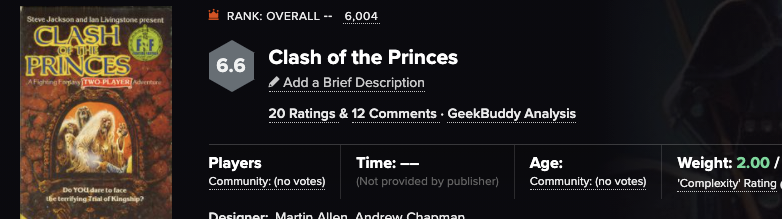
And indeed it is true

In [407]:
# Avaliability on amazon prime if prime is TRUE append 1 otherwise append 0 
df['prime']=df.prime.fillna(0).astype(int)

In [408]:
# Last run to remove unnecassary features and those too hard to mess with
df = df.drop([
    'title',
    'defaultprice',
    'newprice',
    'listprice',
    'mechanics',
    'category',
    'names',
    'price_cleaned',
    'kickstarted',
    'year'
],1)

In [409]:
df.shape

(120832, 1113)

In [410]:
df.iloc[:,:30].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120832 entries, 0 to 120831
Data columns (total 30 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   owned                                 120832 non-null  int64  
 1   avg_rating                            91376 non-null   float64
 2   minplayers                            120830 non-null  float64
 3   maxplayers                            120830 non-null  float64
 4   avg_time                              120830 non-null  float64
 5   age                                   120830 non-null  float64
 6   num_of_awards                         120832 non-null  int64  
 7   averageweight                         120832 non-null  float64
 8   podcasts                              120832 non-null  int64  
 9   prime                                 120832 non-null  int64  
 10  log_owned                             120832 non-null  float64
 11  

##### Fill and drop remaining Na's

In [411]:
# fill missing rating with an average score, 
# probablly wasn't noteworthy but also not 
# bad enoguh for people to care to give it a bad score

df['avg_rating'] = df.avg_rating.fillna(df.avg_rating.mean())

# drop the two games that didn't have min/max players, time, or age
df = df.dropna()

##### Create log_owned and player_range

In [412]:
df['log_owned'] = np.log(df.owned + 1)
# df['num_awards * podcasts'] = df.num_of_awards * df.podcasts
# df['num_awards * maxplayers'] =df.num_of_awards * df.maxplayers
# df['podcasts^2'] = df.podcasts * df.podcasts
# df['awards^2'] = df.num_of_awards * df.num_of_awards

# df['player_range'] = df.maxplayers - df.minplayers

##### Cleaned Data

In [413]:
df.iloc[:,:10].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120830 entries, 0 to 120831
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   owned          120830 non-null  int64  
 1   avg_rating     120830 non-null  float64
 2   minplayers     120830 non-null  float64
 3   maxplayers     120830 non-null  float64
 4   avg_time       120830 non-null  float64
 5   age            120830 non-null  float64
 6   num_of_awards  120830 non-null  int64  
 7   averageweight  120830 non-null  float64
 8   podcasts       120830 non-null  int64  
 9   prime          120830 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 10.1 MB


# Train/Val/Test Split

In [414]:
r_state = 57334

# Split target variable and features
X = df.drop(['avg_rating','owned','log_owned'], 1) #.loc[:,non_zero_features_mask]
y = df.owned

# hold out 20% of the data for final testing (holdout set)
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=r_state)

# Train/Val/Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=113)

#### 1st modeling 

# 1st Lasso out Features 

In [415]:
lasso_all = Lasso(alpha = 4, max_iter=10000).fit(X_train,y_train)
print("Number of features in the model: ",len(lasso_all.coef_))
non_zero_features_mask = np.abs(lasso_all.coef_)>0.0001
print(non_zero_features_mask)
print("Number of non-zero features in the model: ",np.sum(non_zero_features_mask.astype(int)))
print("Fraction of total features used: ",float(np.sum(non_zero_features_mask.astype(int)))/len(lasso_all.coef_))

Number of features in the model:  1110
[False  True False ...  True  True False]
Number of non-zero features in the model:  42
Fraction of total features used:  0.03783783783783784


In [416]:
list(X.iloc[:,non_zero_features_mask].columns)

['maxplayers',
 'age',
 'num_of_awards',
 'averageweight',
 'podcasts',
 'prime',
 '(MECHANIC) Cooperative Game',
 '(MECHANIC) Dice Rolling',
 '(MECHANIC) Hand Management',
 '(MECHANIC) Modular Board',
 '(MECHANIC) Player Elimination',
 '(MECHANIC) Set Collection',
 '(MECHANIC) Team-Based Game',
 '(MECHANIC) Trading',
 '(MECHANIC) Variable Player Powers',
 '(AWARD)golden geek best board game expansion',
 '(AWARD)golden geek best family board game',
 '(AWARD)golden geek best party board game',
 '(AWARD)gra roku game of the year',
 '(AWARD)hra roku',
 "(AWARD)japan boardgame prize voters' selection",
 '(AWARD)jocul anului în românia best game in romanian',
 '(AWARD)juego del año',
 '(AWARD)mind-spielepreis',
 '(AWARD)nederlandse spellenprijs',
 '(AWARD)spiel des jahres',
 '(THEME) Action / Dexterity',
 '(THEME) Card Game',
 "(THEME) Children's Game",
 '(THEME) City Building',
 '(THEME) Expansion for Base-game',
 '(THEME) Fantasy',
 '(THEME) Fighting',
 '(THEME) Medieval',
 '(THEME) Terri

# 1st Redefine X with features selected 

In [417]:
X = X.loc[:,non_zero_features_mask]
X_train = X_train.loc[:,non_zero_features_mask]
X_val = X_val.loc[:,non_zero_features_mask]
X_test = X_test.loc[:,non_zero_features_mask]

In [418]:
coeffs = LinearRegression().fit(X,y).coef_
coeff_df = pd.DataFrame(list(zip(X.columns,np.abs(coeffs))),columns=["features","betas"])
coeff_df.sort_values("betas",ascending=False,inplace=True)
coeff_df.head(50)

,features,betas
21,(AWARD)jocul anului în românia best game in ro...,39277.018551
15,(AWARD)golden geek best board game expansion,5948.924784
20,(AWARD)japan boardgame prize voters' selection,4539.044448
18,(AWARD)gra roku game of the year,4398.522104
19,(AWARD)hra roku,3475.085753
17,(AWARD)golden geek best party board game,3338.095222
24,(AWARD)nederlandse spellenprijs,3046.781067
16,(AWARD)golden geek best family board game,2804.529631
22,(AWARD)juego del año,2736.202864
23,(AWARD)mind-spielepreis,2491.061733


In [419]:
coeff_df[coeff_df['features'] == 'maxplayers']

,features,betas
0,maxplayers,0.012551


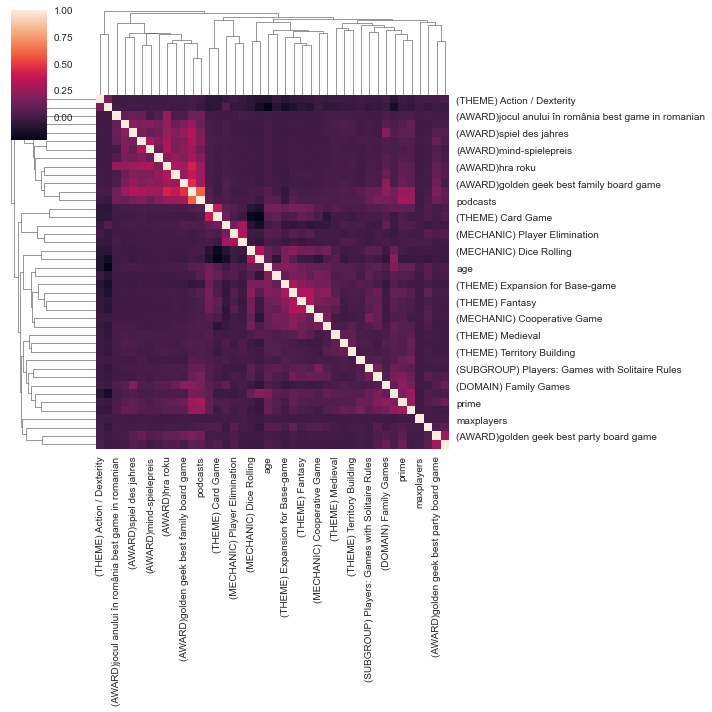

In [420]:
sns.clustermap(X.corr())

#### 2nd modeling

In [426]:
#set up the models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)
X_scaled = scaler.transform(X.values)

lm_reg = Ridge(alpha=1)
lasso = Lasso()


'''
validate

'''

cross_val_scores = np.abs(cross_val_score(lm,X,y,cv=10,scoring="neg_root_mean_squared_error"))
print('10-fold mean RMSE for linear regression: ', np.mean(cross_val_scores))

cross_val_scores = cross_val_score(lm,X,y,cv=10)
print('10-fold mean R^2 for linear regression: ', np.mean(cross_val_scores))

lm.fit(X_train, y_train)
print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

cross_val_scores = np.abs(cross_val_score(lm_reg,X_scaled,y,cv=10,scoring='neg_root_mean_squared_error'))
print('10-fold mean RMSE for ridge regression: ', np.mean(cross_val_scores))

cross_val_scores = np.abs(cross_val_score(lm_reg,X_scaled,y,cv=10))
print('10-fold mean R^2 for ridge regression: ', np.mean(cross_val_scores))

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

cross_val_scores = np.abs(cross_val_score(lasso,X_scaled,y,cv=10,scoring='neg_root_mean_squared_error'))
print('10-fold mean RMSE for lasso regression: ', np.mean(cross_val_scores))

cross_val_scores = np.abs(cross_val_score(lasso,X_scaled,y,cv=10))
print('10-fold mean R^2 for lasso regression: ', np.mean(cross_val_scores))

lasso.fit(X_train_scaled, y_train)
print(f'Lasso train R^2: {lasso.score(X_train_scaled, y_train):.3f}')
print(f'Lasso val R^2: {lasso.score(X_val_scaled, y_val):.3f}')
print(f'Lasso test R^2: {lasso.score(X_test_scaled, y_test):.3f}')

10-fold mean RMSE for linear regression:  1244.1171419394095
10-fold mean R^2 for linear regression:  0.5849790430386588
Linear Regression train R^2: 0.679
Linear Regression val R^2: 0.667
Linear Regression test R^2: 0.758
10-fold mean RMSE for ridge regression:  1244.1114961860228
10-fold mean R^2 for ridge regression:  0.6056807806799699
Ridge Regression train R^2: 0.679
Ridge Regression val R^2: 0.667
Ridge Regression test R^2: 0.758
10-fold mean RMSE for lasso regression:  1244.135772164041
10-fold mean R^2 for lasso regression:  0.605672544311903
Lasso train R^2: 0.679
Lasso val R^2: 0.667
Lasso test R^2: 0.758


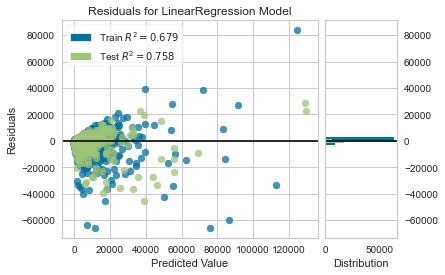

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [422]:
model = LinearRegression()
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show()

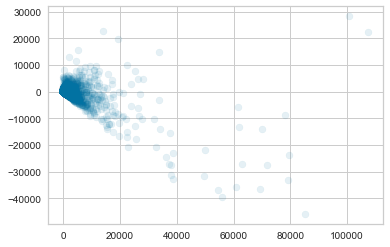

In [423]:
preds = lm.predict(X_test)
residuals = preds - y_test

fig, ax = plt.subplots()
ax.scatter(y_test, residuals, alpha=0.1)

<AxesSubplot:>

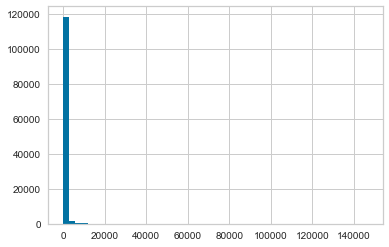

In [424]:
df.owned.hist(bins=50)

# Polynomial Features

In [425]:
#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)
X_poly = poly.transform(X.values)

lm_poly = LinearRegression()

"""
fit score
"""

lm_poly.fit(X_train_poly, y_train)

cross_val_scores = cross_val_score(lm_poly,X,y,cv=10)
print('10-fold mean R^2 for Degree 2 polynomial regression: ', np.mean(cross_val_scores))

print(f'Degree 2 polynomial regression train R^2: {lm_poly.score(X_train_poly, y_train):.3f}')
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
print(f'Degree 2 polynomial regression test R^2: {lm_poly.score(X_test_poly, y_test):.3f}')

10-fold mean R^2 for Degree 2 polynomial regression:  0.5849790430386588
Degree 2 polynomial regression train R^2: 0.874
Degree 2 polynomial regression val R^2: -25093.872
Degree 2 polynomial regression test R^2: -22452.293


# 2nd Lasso out Polynomial Features 

In [383]:
lasso_all = Lasso(alpha = 50000, max_iter=1000).fit(X_train_poly,y_train)
print("Number of features in the model: ",len(lasso_all.coef_))
non_zero_features_mask = np.abs(lasso_all.coef_)>0.0001
print(non_zero_features_mask)
print("Number of non-zero features in the model: ",np.sum(non_zero_features_mask.astype(int)))
print("Fraction of total features used: ",float(np.sum(non_zero_features_mask.astype(int)))/len(lasso_all.coef_))

Number of features in the model:  946
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False 

In [384]:
poly_names = poly.get_feature_names(X_train.columns)

X_train_poly_df = pd.DataFrame(X_train_poly, columns = poly_names).iloc[:,non_zero_features_mask]
X_val_poly_df = pd.DataFrame(X_val_poly, columns = poly_names).iloc[:,non_zero_features_mask]
X_test_poly_df = pd.DataFrame(X_test_poly, columns = poly_names).iloc[:,non_zero_features_mask]
X_poly_df = pd.DataFrame(X_poly, columns = poly_names).iloc[:,non_zero_features_mask]
list(X_poly_df.columns)

IndexError: index 41 is out of bounds for axis 0 with size 41

In [328]:

X_train.head()

,maxplayers,age,num_of_awards,averageweight,podcasts,prime,(MECHANIC) Cooperative Game,(MECHANIC) Dice Rolling,(MECHANIC) Hand Management,(MECHANIC) Modular Board,...,(THEME) Fighting,(THEME) Medieval,(THEME) Territory Building,(THEME) Wargame,(SUBGROUP) Crowdfunding: Kickstarter,(SUBGROUP) Players: Games with Solitaire Rules,(DOMAIN) Family Games,(DOMAIN) Party Games,(DOMAIN) Strategy Games,(DOMAIN) Thematic Games
62869,0.0,0.0,2,0.0000,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58384,6.0,10.0,2,2.0000,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106978,50.0,10.0,2,1.6667,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21751,6.0,0.0,2,1.0000,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107208,4.0,12.0,2,0.0000,0,0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [329]:
X_train_poly_df.head()

,num_of_awards^2,maxplayers num_of_awards^2,maxplayers num_of_awards podcasts,age^2 num_of_awards,age num_of_awards^2,age num_of_awards podcasts,num_of_awards^2 averageweight,num_of_awards^2 prime,num_of_awards^2 (MECHANIC) Hand Management,num_of_awards^2 (AWARD)hra roku,num_of_awards^2 (AWARD)spiel des jahres,num_of_awards^2 (THEME) Card Game,num_of_awards^2 (THEME) Children's Game,num_of_awards^2 (DOMAIN) Family Games,num_of_awards^2 (DOMAIN) Strategy Games,podcasts^3
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,24.0,0.0,200.0,40.0,0.0,8.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,200.0,0.0,200.0,40.0,0.0,6.6668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,24.0,0.0,0.0,0.0,0.0,4.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,16.0,0.0,288.0,48.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [336]:
X_train_merged = pd.concat([X_train, X_train_poly_df], axis=1, ignore_index=True)
X_train_merged

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,14.0,812.0,3.9194,24.0,1.0,0.0,0.0,1.0,0.0,...,6.6668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.0,14.0,106.0,4.2124,48.0,1.0,0.0,1.0,0.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120823,1.0,0.0,2.0,0.0000,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120824,2.0,0.0,2.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120827,99.0,10.0,2.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120828,12.0,14.0,2.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [352]:
coeffs = LinearRegression().fit(X_train_poly,y_train).coef_
coeff_df = pd.DataFrame(list(zip(X_poly_df.columns,np.abs(coeffs))),columns=["features","betas"])
coeff_df.sort_values("betas",ascending=False,inplace=True)
coeff_df.head(50)

,features,betas
0,age num_of_awards,1704.943866
2,num_of_awards podcasts,0.977945
3,podcasts^2,0.325707
1,num_of_awards^2,0.038318


# Pickle my Model

In [452]:
str(np.array(pd.DataFrame(np.zeros(shape=(1,42)), columns = X.columns)))

'[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]'

In [448]:
pd.DataFrame(np.zeros(shape=(1,42)), columns = X.columns).to_pickle('zeros42.pkl')

In [431]:
app_df = X.columns)

['maxplayers',
 'age',
 'num_of_awards',
 'averageweight',
 'podcasts',
 'prime',
 '(MECHANIC) Cooperative Game',
 '(MECHANIC) Dice Rolling',
 '(MECHANIC) Hand Management',
 '(MECHANIC) Modular Board',
 '(MECHANIC) Player Elimination',
 '(MECHANIC) Set Collection',
 '(MECHANIC) Team-Based Game',
 '(MECHANIC) Trading',
 '(MECHANIC) Variable Player Powers',
 '(AWARD)golden geek best board game expansion',
 '(AWARD)golden geek best family board game',
 '(AWARD)golden geek best party board game',
 '(AWARD)gra roku game of the year',
 '(AWARD)hra roku',
 "(AWARD)japan boardgame prize voters' selection",
 '(AWARD)jocul anului în românia best game in romanian',
 '(AWARD)juego del año',
 '(AWARD)mind-spielepreis',
 '(AWARD)nederlandse spellenprijs',
 '(AWARD)spiel des jahres',
 '(THEME) Action / Dexterity',
 '(THEME) Card Game',
 "(THEME) Children's Game",
 '(THEME) City Building',
 '(THEME) Expansion for Base-game',
 '(THEME) Fantasy',
 '(THEME) Fighting',
 '(THEME) Medieval',
 '(THEME) Terri

In [429]:
import pickle
pickle.dump(lm, open("lr_game_model.pkl",'wb'))

#### log_owned results

In [49]:
#set up the models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)
lasso = Lasso()

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

'''
validate

'''

cross_val_scores = np.abs(cross_val_score(lm,X,y,cv=10,scoring="neg_root_mean_squared_error"))
print('10-fold mean RMSE for linear regression: ', np.mean(cross_val_scores))


lm.fit(X_train, y_train)
print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
cross_val_scores = cross_val_score(lm,X,y,cv=10)
print('10-fold mean RMSE for linear regression: ', np.mean(cross_val_scores))
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

cross_val_scores = np.abs(cross_val_score(lm_reg,X_train_scaled,y_train,cv=10,scoring='neg_root_mean_squared_error'))
print('10-fold mean RMSE for ridge regression: ', np.mean(cross_val_scores))

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

cross_val_scores = np.abs(cross_val_score(lasso,X_train_scaled,y_train,cv=10,scoring='neg_root_mean_squared_error'))
print('10-fold mean RMSE for lasso regression: ', np.mean(cross_val_scores))

lasso.fit(X_train_scaled, y_train)
print(f'Lasso train R^2: {lasso.score(X_train_scaled, y_train):.3f}')
print(f'Lasso val R^2: {lasso.score(X_val_scaled, y_val):.3f}')
print(f'Lasso test R^2: {lasso.score(X_test_scaled, y_test):.3f}')

# lm_poly.fit(X_train_poly, y_train)
# print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_train_poly, y_train):.3f}')
# cross_val_scores = cross_val_score(lm,X,y,cv=10)
# print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
# print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_test_poly, y_test):.3f}')

10-fold mean RMSE for linear regression:  1.3808800752128643
Linear Regression train R^2: 0.619
10-fold mean RMSE for linear regression:  0.6149040937050894
Linear Regression val R^2: 0.614
Linear Regression test R^2: 0.618
10-fold mean RMSE for ridge regression:  1.3812263407252705
Ridge Regression train R^2: 0.619
Ridge Regression val R^2: 0.614
Ridge Regression test R^2: 0.618
10-fold mean RMSE for lasso regression:  2.059072952210347
Lasso train R^2: 0.144
Lasso val R^2: 0.145
Lasso test R^2: 0.142


<AxesSubplot:>

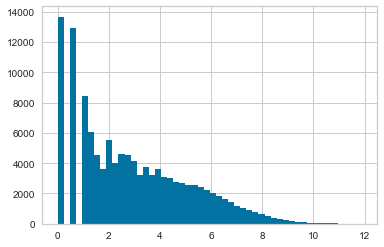

In [52]:
df.log_owned.hist(bins=50)

#### Lasso CV

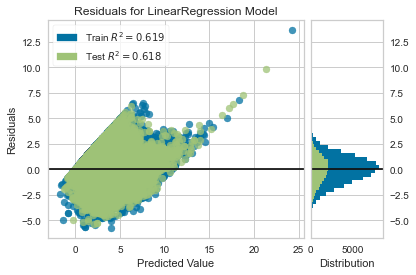

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [50]:
model = LinearRegression()
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show()

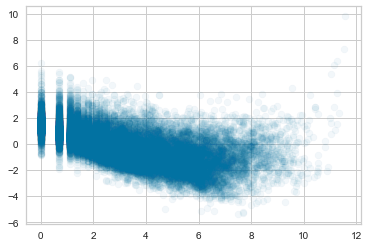

In [51]:
preds = lm.predict(X_test)
residuals = preds - y_test

fig, ax = plt.subplots()
ax.scatter(y_test, residuals, alpha=0.05)

#### avg_rating results

In [57]:
#set up the models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)
lasso = Lasso()

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

'''
validate

'''

cross_val_scores = np.abs(cross_val_score(lm,X,y,cv=10,scoring="neg_root_mean_squared_error"))
print('10-fold mean RMSE for linear regression: ', np.mean(cross_val_scores))


lm.fit(X_train, y_train)
print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
cross_val_scores = cross_val_score(lm,X,y,cv=10)
print('10-fold mean RMSE for linear regression: ', np.mean(cross_val_scores))
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

cross_val_scores = np.abs(cross_val_score(lm_reg,X_train_scaled,y_train,cv=10,scoring='neg_root_mean_squared_error'))
print('10-fold mean RMSE for ridge regression: ', np.mean(cross_val_scores))

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

cross_val_scores = np.abs(cross_val_score(lasso,X_train_scaled,y_train,cv=10,scoring='neg_root_mean_squared_error'))
print('10-fold mean RMSE for lasso regression: ', np.mean(cross_val_scores))

lasso.fit(X_train_scaled, y_train)
print(f'Lasso train R^2: {lasso.score(X_train_scaled, y_train):.3f}')
print(f'Lasso val R^2: {lasso.score(X_val_scaled, y_val):.3f}')
print(f'Lasso test R^2: {lasso.score(X_test_scaled, y_test):.3f}')

# lm_poly.fit(X_train_poly, y_train)
# print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_train_poly, y_train):.3f}')
# cross_val_scores = cross_val_score(lm,X,y,cv=10)
# print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
# print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_test_poly, y_test):.3f}')

10-fold mean RMSE for linear regression:  1.2190641150078416
Linear Regression train R^2: 0.260
10-fold mean RMSE for linear regression:  0.25771912006981257
Linear Regression val R^2: 0.259
Linear Regression test R^2: 0.263
10-fold mean RMSE for ridge regression:  1.216877106138351
Ridge Regression train R^2: 0.260
Ridge Regression val R^2: 0.259
Ridge Regression test R^2: 0.263
10-fold mean RMSE for lasso regression:  1.412001695137025
Lasso train R^2: 0.000
Lasso val R^2: -0.000
Lasso test R^2: -0.000


<AxesSubplot:>

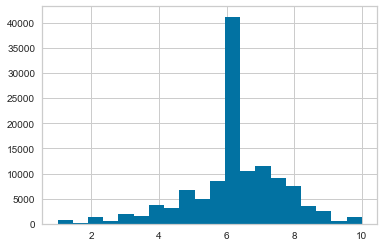

In [65]:
df.avg_rating.hist(bins=20)

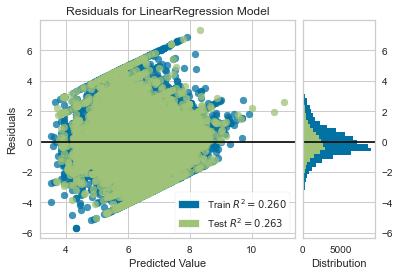

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [58]:
model = LinearRegression()
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show()

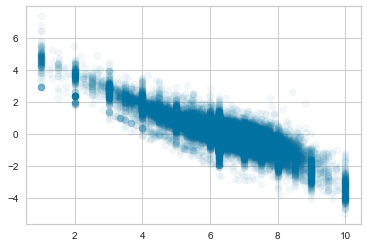

In [59]:
preds = lm.predict(X_test)
residuals = preds - y_test

fig, ax = plt.subplots()
ax.scatter(y_test, residuals, alpha=0.05)

#### Results without Awards info

In [157]:
#set up the models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)
X_scaled = scaler.transform(X.values)

lm_reg = Ridge(alpha=1)
lasso = Lasso()


'''
validate

'''

cross_val_scores = np.abs(cross_val_score(lm,X,y,cv=10,scoring="neg_root_mean_squared_error"))
print('10-fold mean RMSE for linear regression: ', np.mean(cross_val_scores))

cross_val_scores = cross_val_score(lm,X,y,cv=10)
print('10-fold mean R^2 for linear regression: ', np.mean(cross_val_scores))

lm.fit(X_train, y_train)
print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

cross_val_scores = np.abs(cross_val_score(lm_reg,X_scaled,y,cv=10,scoring='neg_root_mean_squared_error'))
print('10-fold mean RMSE for ridge regression: ', np.mean(cross_val_scores))

cross_val_scores = np.abs(cross_val_score(lm_reg,X_scaled,y,cv=10))
print('10-fold mean R^2 for ridge regression: ', np.mean(cross_val_scores))

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

cross_val_scores = np.abs(cross_val_score(lasso,X_scaled,y,cv=10,scoring='neg_root_mean_squared_error'))
print('10-fold mean RMSE for lasso regression: ', np.mean(cross_val_scores))

cross_val_scores = np.abs(cross_val_score(lasso,X_scaled,y,cv=10))
print('10-fold mean R^2 for lasso regression: ', np.mean(cross_val_scores))

lasso.fit(X_train_scaled, y_train)
print(f'Lasso train R^2: {lasso.score(X_train_scaled, y_train):.3f}')
print(f'Lasso val R^2: {lasso.score(X_val_scaled, y_val):.3f}')
print(f'Lasso test R^2: {lasso.score(X_test_scaled, y_test):.3f}')

10-fold mean RMSE for linear regression:  1437.121224161249
10-fold mean R^2 for linear regression:  0.4329581410725808
Linear Regression train R^2: 0.498
Linear Regression val R^2: 0.617
Linear Regression test R^2: 0.633
10-fold mean RMSE for ridge regression:  1437.1183100196497
10-fold mean R^2 for ridge regression:  0.6217792130018599
Ridge Regression train R^2: 0.498
Ridge Regression val R^2: 0.617
Ridge Regression test R^2: 0.633
10-fold mean RMSE for lasso regression:  1437.0962472999306
10-fold mean R^2 for lasso regression:  0.6216500414937595
Lasso train R^2: 0.498
Lasso val R^2: 0.617
Lasso test R^2: 0.633


# PCA

In [216]:
X.head()

,minplayers,maxplayers,avg_time,age,num_of_awards,averageweight,podcasts,prime,(MECHANIC) Acting,(MECHANIC) Action Drafting,...,(SUBGROUP) Sports: Tennis,(SUBGROUP) Country: Portugal,(DOMAIN) Abstract Games,(DOMAIN) Children's Games,(DOMAIN) Customizable Games,(DOMAIN) Family Games,(DOMAIN) Party Games,(DOMAIN) Strategy Games,(DOMAIN) Thematic Games,(DOMAIN) Wargames
41822,2.0,2.0,30.0,0.0,2,0.0000,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46627,2.0,6.0,30.0,0.0,2,0.0000,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41209,2.0,10.0,90.0,0.0,2,2.0000,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44440,2.0,4.0,10.0,0.0,2,0.0000,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14109,1.0,6.0,90.0,14.0,2,1.7143,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [217]:
pca = PCA()
transformed_pca_x = pca.fit_transform(X)
#create component indices
component_names = ["component_"+str(comp) for comp in range(1, len(pca.explained_variance_)+1)]

#generate new component dataframe
transformed_pca_x = pd.DataFrame(transformed_pca_x,columns=component_names)
transformed_pca_x.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_1101,component_1102,component_1103,component_1104,component_1105,component_1106,component_1107,component_1108,component_1109,component_1110
0,-373.961870,-4.093482,-5.035672,-7.722492,0.181880,0.552868,0.143285,-0.003763,0.117858,0.047201,...,2.250405e-11,2.333766e-11,-1.585337e-16,-1.232860e-17,-3.010409e-17,1.021288e-17,5.202766e-18,1.384258e-17,6.284745e-17,-4.905696e-18
1,-373.961869,-0.093315,-5.018612,-7.704982,0.177715,0.555076,0.159723,0.147279,-0.210125,0.123501,...,1.054295e-12,1.283877e-12,1.239018e-18,-3.879443e-18,6.733261e-18,1.589086e-18,-3.022564e-19,-1.156846e-18,-1.547195e-18,1.796418e-19
2,-313.961869,3.905402,-4.991378,-7.595667,0.232471,-1.653535,0.044733,1.149982,-0.690142,0.105366,...,3.897417e-13,9.338405e-13,3.982341e-19,5.730277e-19,-2.528986e-19,-1.276423e-19,4.511133e-19,-8.779223e-20,-6.234878e-20,-9.416205e-20
3,-393.961869,-2.093497,-5.026479,-7.727738,0.183049,0.557545,0.161073,-0.173556,0.135872,0.031811,...,4.678674e-12,-4.325305e-12,-1.037771e-18,-1.333883e-18,-6.649478e-18,-5.917054e-18,6.431512e-18,-6.952794e-19,-2.963378e-18,-7.717030e-19
4,-313.961865,-0.080594,-4.911624,6.338377,-0.321252,-0.820839,-1.155431,0.415778,-0.160980,-0.683133,...,2.019578e-11,2.288749e-11,-9.949878e-17,-2.140053e-17,1.945049e-19,2.056535e-17,-1.939899e-17,5.465649e-18,5.138687e-17,-3.357198e-18


In [219]:
#generate component loadings on original features
component_matrix = pd.DataFrame(pca.components_,index=component_names,columns = X.columns)
#add additional columns to describe what
component_matrix["explained_variance_ratio"] = pca.explained_variance_ratio_
component_matrix["eigenvalue"] = pca.explained_variance_
figure = sns.mpl.pyplot.figure(figsize=(18,6))
#add 3 subplots one at a time

<Figure size 1296x432 with 0 Axes>

In [229]:
lr=LinearRegression()
mean_squared_errors = np.abs(cross_val_score(lr,transformed_pca_x.iloc[:,:20],y,cv=50,scoring='neg_mean_squared_error'))
r2_errors = cross_val_score(lr,transformed_pca_x.iloc[:,:20],y,cv=50)
#apply square root to each fold
root_mean_squared_errors = list(map(np.sqrt,mean_squared_errors))
print("50-fold mean RMSE: ", np.mean(root_mean_squared_errors))
print("50-fold std RMSE: ", np.std(root_mean_squared_errors))
print("50-fold mean R^2: ", np.mean(r2_errors))

50-fold mean RMSE:  1254.4337598867369
50-fold std RMSE:  704.682921018324
50-fold mean R^2:  0.5219297762925678


#### Lasso CV

In [378]:
# Define the folds
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=2**32-1)

# For each alpha provided in `alphas`, this model trains and tests `n_folds` models 
# (one for each fold in `cv`)
lm_cv = LassoCV(alphas=np.arange(0.01, 2.01, 0.01),
                normalize=True,
                cv=kfold)

lm_cv.fit(X, y)

# Get the errors for each fold, for each alpha
alphas = lm_cv.alphas_  # This is not the `=alphas` input; it may be in a different order (i.e., reverse)
errors = lm_cv.mse_path_

df_errors = pd.DataFrame(index=alphas,
                         columns=[f'fold_{i+1}' for i in range(n_folds)],
                         data=errors)

In [379]:
# Take the average of the errors for each fold (for each alpha)
df_errors['error_mean'] = df_errors.mean(axis=1)
df_errors.sort_values('error_mean').head()

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,error_mean
0.01,1.313360e+06,1.206369e+06,1.375595e+06,1.326905e+06,1.270820e+06,851524.972044,1.996497e+06,1.969881e+06,6.067205e+06,1.465005e+06,1.884316e+06
0.02,1.309122e+06,1.208073e+06,1.381286e+06,1.326736e+06,1.275244e+06,849584.393125,2.005843e+06,1.975027e+06,6.074386e+06,1.457968e+06,1.886327e+06
0.03,1.305940e+06,1.210884e+06,1.388706e+06,1.326765e+06,1.280029e+06,848656.499429,2.014295e+06,1.981302e+06,6.086286e+06,1.451849e+06,1.889471e+06
0.04,1.304008e+06,1.215020e+06,1.397656e+06,1.327792e+06,1.285676e+06,848946.650607,2.024712e+06,1.988710e+06,6.099148e+06,1.447000e+06,1.893867e+06
0.05,1.303014e+06,1.219828e+06,1.407072e+06,1.328962e+06,1.292381e+06,850140.911394,2.035934e+06,1.996349e+06,6.116755e+06,1.442766e+06,1.899320e+06


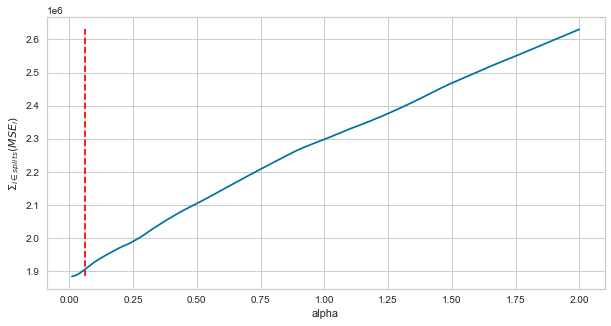

In [380]:
plt.figure(figsize=(10, 5))

g = sns.lineplot(data=df_errors,
                 x=df_errors.index,
                 y='error_mean')

# Show the selected alpha, above
plot_alpha = 0.06
g.vlines(plot_alpha, df_errors['error_mean'].min(), df_errors['error_mean'].max(), 
         color='red', linestyles='dashed')

g.set_xlabel('alpha')
g.set_ylabel('$\Sigma_{i \in splits}(MSE_i)$');

In [381]:
# LassoCV automatically picks the best model, and returns *that* model
# So, the alpha, the coefficients, etc. all relate to that "best" model
lm_cv.alpha_.round(4)

lm_cv.coef_

pd.Series(index=X.columns,
          data=lm_cv.coef_).head(30)

year                                   -0.364496
minplayers                             -4.953735
maxplayers                              0.000000
age                                    -0.000000
num_of_awards                          12.620739
averageweight                          40.706713
podcasts                              231.418900
prime                                1050.745798
(MECHANIC) Dice Rolling                12.148892
(MECHANIC) Hand Management             48.509720
(MECHANIC) Roll / Spin and Move        21.933213
(MECHANIC) Variable Player Powers      49.353793
(MECHANIC) Set Collection               6.931836
(MECHANIC) Card Drafting                2.662179
(MECHANIC) Hexagon Grid                20.781606
(MECHANIC) Simulation                  -6.530118
(MECHANIC) Cooperative Game            64.475776
(MECHANIC) Modular Board               11.596325
(MECHANIC) Tile Placement             -17.277774
(MECHANIC) Action Points              -56.302966
(MECHANIC) Grid Move

In [382]:
pd.Series(index=X.columns,
          data=lm_cv.coef_).head(100)

year                 -0.364496
minplayers           -4.953735
maxplayers            0.000000
age                  -0.000000
num_of_awards        12.620739
                       ...    
(THEME) Racing      -13.773142
(THEME) Medieval     22.625132
(THEME) Deduction    25.253900
(THEME) Book        -61.902228
(THEME) Horror        0.000000
Length: 100, dtype: float64